## Week 4: Using real world data

Daily Minimum Temperatures in Melbourne dataset

In [1]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass

In [2]:
TEMPERATURES_CSV = '../../../data/daily-min-temperatures.csv'

with open(TEMPERATURES_CSV, 'r') as csvfile:
    for _ in range (3):
        print(csvfile.readline())

"Date","Temp"

"1981-01-01",20.7

"1981-01-02",17.9



In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
def parse_data_from_file(filename):
    
    times = []
    temperatures = []

    with open(filename) as csvfile:
        
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        
        for row in reader:
            times.append(row[0])
            temperatures.append(float(row[1]))
            
    return times, temperatures


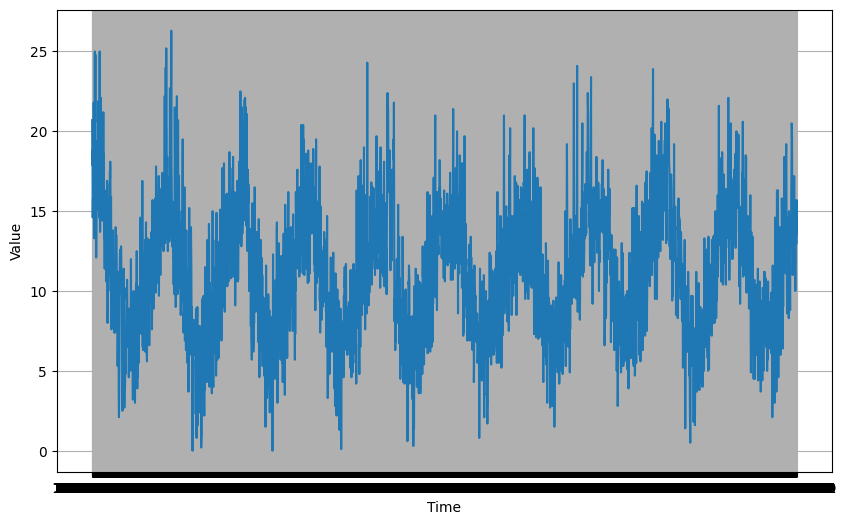

In [5]:
@dataclass
class G:
    TEMPERATURES_CSV = '../../../data/daily-min-temperatures.csv'
    times, temperatures = parse_data_from_file(TEMPERATURES_CSV)
    TIME = np.array(times)
    SERIES = np.array(temperatures)
    SPLIT_TIME = 2500
    WINDOW_SIZE = 64
    BATCH_SIZE = 256
    SHUFFLE_BUFFER_SIZE = 1000


plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

In [6]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [7]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))

    ds = ds.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
    
    return ds

train_set = windowed_dataset(series_train, window_size=64, batch_size=256, shuffle_buffer=1000)

In [8]:
def create_model():
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(64, 3, padding='causal', activation='relu', input_shape=[G.WINDOW_SIZE, 1]),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)
    ]) 

    model.compile(optimizer='adam',
                  loss='huber',
                  metrics=["mae"])  

    return model

In [9]:
model = create_model()

history = model.fit(train_set, epochs=50)

Epoch 1/50
10/10 [==============================] - 7s 221ms/step - loss: 9.2751 - mae: 9.7736
Epoch 2/50
10/10 [==============================] - 1s 42ms/step - loss: 7.4739 - mae: 7.9707
Epoch 3/50
10/10 [==============================] - 1s 47ms/step - loss: 5.6399 - mae: 6.1280
Epoch 4/50
10/10 [==============================] - 1s 48ms/step - loss: 4.0485 - mae: 4.5253
Epoch 5/50
10/10 [==============================] - 1s 46ms/step - loss: 3.0455 - mae: 3.5153
Epoch 6/50
10/10 [==============================] - 1s 42ms/step - loss: 2.7269 - mae: 3.1937
Epoch 7/50
10/10 [==============================] - 1s 40ms/step - loss: 2.7261 - mae: 3.1936
Epoch 8/50
10/10 [==============================] - 1s 45ms/step - loss: 2.7124 - mae: 3.1792
Epoch 9/50
10/10 [==============================] - 1s 44ms/step - loss: 2.6910 - mae: 3.1571
Epoch 10/50
10/10 [==============================] - 1s 47ms/step - loss: 2.6817 - mae: 3.1470
Epoch 11/50
10/10 [==============================] - 1s 43

In [10]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

In [11]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).cache().prefetch(tf.data.AUTOTUNE)

    forecast = model.predict(ds)

    return forecast

36/36 [==============================] - 1s 12ms/step


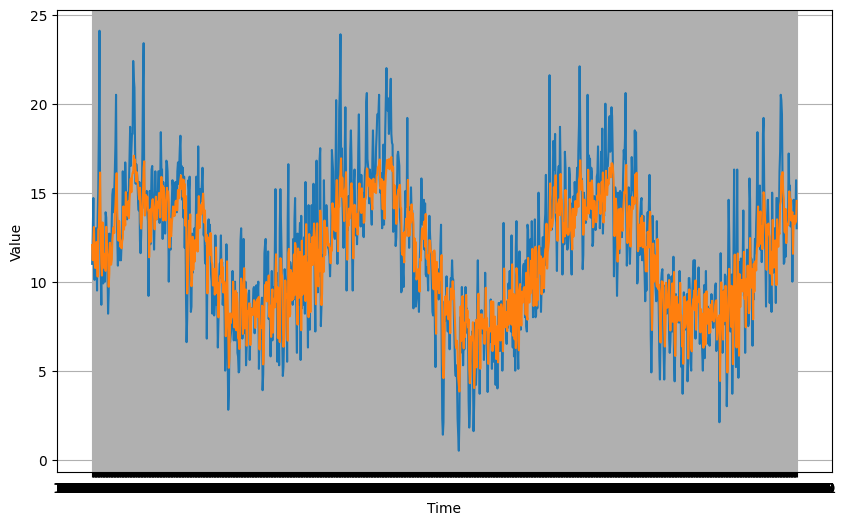

In [12]:
forecast_series = G.SERIES[G.SPLIT_TIME - G.WINDOW_SIZE:-1]
rnn_forecast = model_forecast(model, forecast_series, G.WINDOW_SIZE).squeeze()

plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [13]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 5.48, mae: 1.83 for forecast


To pass this assignment your forecast should achieve a MSE of 6 or less and a MAE of 2 or less.

In [14]:
# model.save("my_model.h5")